In [2]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [3]:
df_train = pd.read_csv('../input/train.csv')

In [4]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [4]:
# df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
# df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [5]:
df_hist_trans['purchase_amount'] = np.round(df_hist_trans['purchase_amount'] / 0.00150265118 + 497.06,2)
df_new_merchant_trans['purchase_amount'] = np.round(df_new_merchant_trans['purchase_amount'] / 0.00150265118 + 497.06,2)

In [6]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [7]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [8]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    
print(df_train.shape)

(201917, 6)


In [9]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

print(df_train.shape)

(201917, 43)


In [10]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

print(df_train.shape)

(201917, 78)


In [11]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()

0

In [12]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [13]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [14]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)
    
print(df_train.shape)

(201917, 87)


In [15]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

print(df_train.shape)

(201917, 102)


In [16]:
df_test.shape

(123623, 100)

In [17]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [18]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")

In [19]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [20]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers']]
target = 2**df_train['target']
target_outlier = df_train["outliers"]

In [29]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    "max_bin": 256,  # なし
    'learning_rate': 0.001,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    print("\n")

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 865.373	valid_1's rmse: 79.6837
Early stopping, best iteration is:
[5]	training's rmse: 868.271	valid_1's rmse: 79.1416
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 860.853	valid_1's rmse: 195.664
Early stopping, best iteration is:
[34]	training's rmse: 862.809	valid_1's rmse: 195.599
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 859.498	valid_1's rmse: 220.943
[200]	training's rmse: 856.86	valid_1's rmse: 221.071
Early stopping, best iteration is:
[111]	training's rmse: 859.236	valid_1's rmse: 220.924
fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 255.344	valid_1's rmse: 1661.38
[200]	training's rmse: 254.609	valid_1's rmse: 1661.25
[300]	training's rmse: 253.932	valid_1's rmse: 1661.09
[400]	training's rmse: 253.301	valid_1's rmse: 1660.98
[500]	training

776.6478400693645

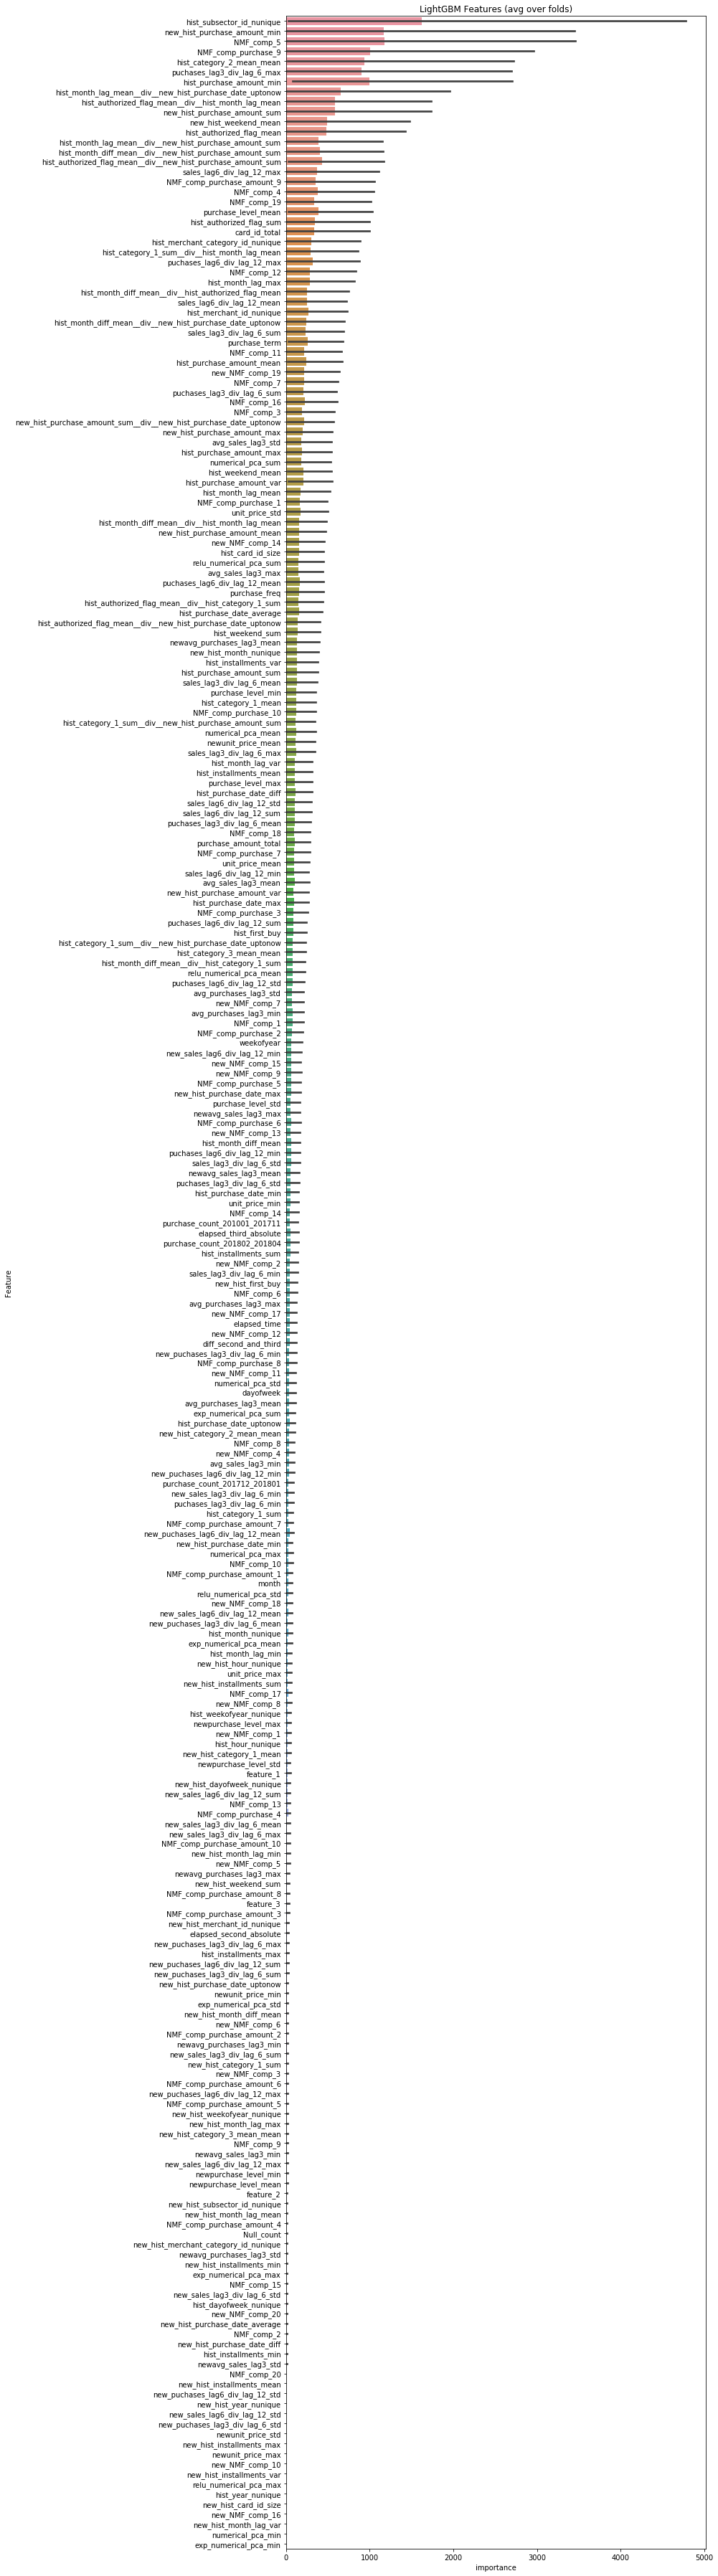

In [33]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [36]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,NMF_comp_purchase_amount_2,NMF_comp_purchase_amount_3,NMF_comp_purchase_amount_4,NMF_comp_purchase_amount_5,NMF_comp_purchase_amount_6,NMF_comp_purchase_amount_7,NMF_comp_purchase_amount_8,NMF_comp_purchase_amount_9,NMF_comp_purchase_amount_10,Null_count
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820283,9,23,35,7,...,5.983064,2.261592,0.322373,0.000000,1.225246,0.688880,0.000000,0.660617,1.360170,0
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392913,12,24,50,7,...,4.128049,2.414238,1.483851,1.646023,0.906651,0.850939,1.283332,0.359787,1.145683,0
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.688056,10,14,22,7,...,0.161178,0.188551,0.108761,0.596203,0.031639,0.074399,0.198585,0.111440,0.000000,11
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142495,6,16,20,7,...,0.000000,0.000000,2.032159,0.000000,0.129208,0.601303,0.000000,0.887256,0.076492,0
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0.159749,4,22,17,7,...,0.000000,0.755080,0.122213,0.000000,0.730396,2.103242,0.000000,0.000000,0.904675,0


In [40]:
df_oof = pd.DataFrame({"card_id":df_train.card_id,"target_raw":oof})
df_predictions = pd.DataFrame({"card_id":df_test.card_id, "target_raw":predictions})

df_target_raw = pd.concat([df_oof, df_predictions], axis=0)

In [41]:
df_target_raw.to_csv("../input/target_raw_20190217.csv", index=False)